# **Core Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our core stock data, scaling and performing PCA (Principle Component Analysis) as well as set up lag and rolling windows.  We will also create new features to help our forthcoming baseline models in the upcoming notebooks.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_data.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
core_stock_data.head()
core_stock_data.shape

(13650, 27)

#### Before we get started I want to address outliers in our data.  I will address this by calculating the z_score and defining the threshold for outliers based on how many std (standard deviations) away from the mean the data points are, then display how many outliers we have per feature.  I can then adjust the threshold as necessary before filtering the dataframe to remove them.

In [3]:
numeric_cols = core_stock_data.select_dtypes(include = [np.number])
z_scores = np.abs(stats.zscore(numeric_cols))
threshold = 3 # Common threshold starting std modifier

outliers = (z_scores > threshold)

print(outliers.sum(axis = 0))


Close_core           29
Volume_core         415
Open_core            27
High_core            26
Low_core             27
SMA_core              0
EMA_core              5
RMA_core            229
RSI_core              0
BBM_core              0
BBU_core              0
BBL_core              1
MACD_core           308
MACD_Signal_core    304
MACD_Hist_core      310
ADX_14_core          69
CCI_20_core          50
ATR_14_core         243
Stoch_K_core          0
Stoch_D_core          0
Momentum_1_core     265
Momentum_3_core     264
Momentum_7_core     284
Momentum_30_core    315
Momentum_50_core    295
OBV_core            406
dtype: int64


#### Our Volume feature has an alarming amount of outliers, and as we know Volume is used to calculate a lot of our other other custom features.  We will need to normalize the Volume feature so we can figure out what's going on.  Let's take a closer look with a plot.

In [4]:
# We will look at the distribution of Volume here.
fig = px.histogram(core_stock_data, x = 'Volume_core',
                nbins = 100,
                title = 'Volume Distribution',
                labels = {'Volume' : 'Trading Volume'},
                marginal = 'box',
                histnorm = 'percent')

fig.update_layout(bargap = 0.1,
                xaxis_title = 'Volume',
                yaxis_title = 'Percentage',
                showlegend = False)

fig.show()

#### There is a heavy right-skew, which shows that we have a positive skew.  This means that there are a few exceptionally high data values (our outliers) that are distorting our statistical measures.  We will look to normalize this data a bit so our statistics and custom features are calculated appropriately, and will do so using a log transform method.

In [5]:
def volume_log_transform(core_stock_data):
    core_stock_data['Volume_core'] = np.log1p(core_stock_data['Volume_core'])
    return core_stock_data

core_stock_data = volume_log_transform(core_stock_data)



#### Now we will replot the Volume feature to see how it looks after the log transform.

In [6]:
fig = px.histogram(core_stock_data,
                x = 'Volume_core',
                marginal = 'box',
                title = 'Volume Distribution After Log Transformation',
                )

fig.update_layout(bargap = 0.2)

fig.show()

#### This is much better, there are few fewer outliers shown in the top part of the plot and you can see the bell curve shape for our Volume feature.

#### Let's now apply this method to all of our numeric columns, also applying z_scores as well after the log transform.  We will then view each feature's respective distribution from the log transform.

In [7]:
# We will be inserting logic to replace any 0 digits in our data with an extremely small number, the log transform doesn't work well with 0s or negative numbers.
def log_transform_and_zscore(dataframe):
    numeric_cols = dataframe.select_dtypes(include = [np.number])
    
    for col in numeric_cols:
        numeric_cols[col] = numeric_cols[col].apply(lambda x : 1e-10 if x <= 0 else x)
    
    log_transformed_data = np.log1p(numeric_cols)
    
    z_scores = np.abs(stats.zscore(log_transformed_data))
    
    threshold = 3
    
    outliers = (z_scores >= threshold)
    
    outliers_summary = outliers.sum(axis = 0)
    
    filtered_data = log_transformed_data[(~outliers).all(axis = 1)]
        
    return filtered_data, outliers_summary

transformed_data, outliers_summary = log_transform_and_zscore(core_stock_data)

print(outliers_summary)



Close_core          197
Volume_core           1
Open_core           197
High_core           196
Low_core            199
SMA_core            180
EMA_core            205
RMA_core            236
RSI_core            138
BBM_core            180
BBU_core            185
BBL_core            152
MACD_core            67
MACD_Signal_core     64
MACD_Hist_core      239
ADX_14_core          24
CCI_20_core           0
ATR_14_core           0
Stoch_K_core        265
Stoch_D_core        138
Momentum_1_core     144
Momentum_3_core      65
Momentum_7_core      30
Momentum_30_core      0
Momentum_50_core      0
OBV_core              0
dtype: int64


#### Much better progress, our Volume feature has been almost entirely rid of outliers and great progress on almost every single other feature.  The only downside is that outliers were actually found in two features (Stoch_K_core, Stoch_D_core).  This is something that is plausible when the log transform is performed and the data is 'spread out', the outliers that weren't apparent before now are reported.  Since the outlier value quantity is extremely low though at this point for just two features and everything else looks fine we will move forward at this time.

#### Now we will create new custom features for our core data, as well as set up the lag windows and features here.

In [9]:


# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Open_core', 'High_core', 'Low_core', 'Volume_core','Close_core', 'EMA_core', 'SMA_core', 'RMA_core', 'RSI_core', 'BBM_core', 'BBL_core', 'BBU_core', 'MACD_core', 'MACD_Signal_core', 'MACD_Hist_core', 'ADX_14_core', 'CCI_20_core', 'ATR_14_core', 'Stoch_K_core', 'Stoch_D_core', 'Momentum_1_core', 'Momentum_3_core', 'Momentum_7_core', 'Momentum_30_core', 'Momentum_50_core', 'OBV_core']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        core_stock_data[f'{feature}_Lag_{lag}'] = core_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
core_stock_data['Open_Lag_Avg_1_3_core'] = core_stock_data[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].mean(axis = 1)
core_stock_data['Open_Lag_Std_1_3_core'] = core_stock_data[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].std(axis = 1)

core_stock_data['High_Lag_Avg_1_3_core'] = core_stock_data[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].mean(axis = 1)
core_stock_data['High_Lag_Std_1_3_core'] = core_stock_data[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].std(axis = 1)

core_stock_data['Low_Lag_Avg_1_3_core'] = core_stock_data[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].mean(axis = 1)
core_stock_data['Low_Lag_Std_1_3_core'] = core_stock_data[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].std(axis = 1)

core_stock_data['Volume_Lag_Avg_1_3_core'] = core_stock_data[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].mean(axis = 1)
core_stock_data['Volume_Lag_Std_1_3_core'] = core_stock_data[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].std(axis = 1)

core_stock_data['EMA_Lag_Avg_1_3_core'] = core_stock_data[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].mean(axis = 1)
core_stock_data['EMA_Lag_Std_1_3_core'] = core_stock_data[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].std(axis = 1)

core_stock_data['SMA_Lag_Avg_1_3_core'] = core_stock_data[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].mean(axis = 1)
core_stock_data['SMA_Lag_Std_1_3_core'] = core_stock_data[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].std(axis = 1)

core_stock_data['RMA_Lag_Avg_1_3_core'] = core_stock_data[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].mean(axis = 1)
core_stock_data['RMA_Lag_Std_1_3_core'] = core_stock_data[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].std(axis = 1)

core_stock_data['RSI_Lag_Avg_1_3_core'] = core_stock_data[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].mean(axis = 1)
core_stock_data['RSI_Lag_Std_1_3_core'] = core_stock_data[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].std(axis = 1)

core_stock_data['BBM_Lag_Avg_1_3_core'] = core_stock_data[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].mean(axis = 1)
core_stock_data['BBM_Lag_Std_1_3_core'] = core_stock_data[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].std(axis = 1)

core_stock_data['BBU_Lag_Avg_1_3_core'] = core_stock_data[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].mean(axis = 1)
core_stock_data['BBU_Lag_Std_1_3_core'] = core_stock_data[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].std(axis = 1)

core_stock_data['BBL_Lag_Avg_1_3_core'] = core_stock_data[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].mean(axis = 1)
core_stock_data['BBL_Lag_Std_1_3_core'] = core_stock_data[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].std(axis = 1)

core_stock_data['Stoch_K_Lag_Avg_1_3_core'] = core_stock_data[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].mean(axis = 1)
core_stock_data['Stoch_K_Lag_Std_1_3_core'] = core_stock_data[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].std(axis = 1)

core_stock_data['Stoch_D_Lag_Avg_1_3_core'] = core_stock_data[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].mean(axis = 1)
core_stock_data['Stoch_D_Lag_Std_1_3_core'] = core_stock_data[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].std(axis = 1)

core_stock_data['MACD_Lag_Avg_1_3_core'] = core_stock_data[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].mean(axis = 1)
core_stock_data['MACD_Lag_Std_1_3_core'] = core_stock_data[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].std(axis = 1)

core_stock_data['MACD_Signal_Lag_Avg_1_3_core'] = core_stock_data[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].mean(axis = 1)
core_stock_data['MACD_Signal_Lag_Std_1_3_core'] = core_stock_data[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].std(axis = 1)

core_stock_data['MACD_Hist_Avg_1_3_core'] = core_stock_data[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].mean(axis = 1)
core_stock_data['MACD_Hist_Lag_Std_1_3_core'] = core_stock_data[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].std(axis = 1)

core_stock_data['ADX_14_Lag_Avg_1_3_core'] = core_stock_data[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].mean(axis = 1)
core_stock_data['ADX_14_Lag_Std_1_3_core'] = core_stock_data[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].std(axis = 1)

core_stock_data['CCI_20_Lag_Avg_1_3_core'] = core_stock_data[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].mean(axis = 1)
core_stock_data['CCI_20_Lag_Std_1_3_core'] = core_stock_data[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].std(axis = 1)

core_stock_data['ATR_14_Lag_Avg_1_3_core'] = core_stock_data[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].mean(axis = 1)
core_stock_data['ATR_14_Lag_Std_1_3_core'] = core_stock_data[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].std(axis = 1)

core_stock_data['Momentum_1_Lag_Avg_1_3_core'] = core_stock_data[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].mean(axis = 1)
core_stock_data['Momentum_1_Lag_Std_1_3_core'] = core_stock_data[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].std(axis = 1)

core_stock_data['Momentum_3_Lag_Avg_1_3_core'] = core_stock_data[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].mean(axis = 1)
core_stock_data['Momentum_3_Lag_Std_1_3_core'] = core_stock_data[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].std(axis = 1)

core_stock_data['Momentum_7_Lag_Avg_1_3_core'] = core_stock_data[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].mean(axis = 1)
core_stock_data['Momentum_7_Lag_Std_1_3_core'] = core_stock_data[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].std(axis = 1)

core_stock_data['Momentum_30_Lag_Avg_1_3_core'] = core_stock_data[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].mean(axis = 1)
core_stock_data['Momentum_30_Lag_Std_1_3_core'] = core_stock_data[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].std(axis = 1)

core_stock_data['Momentum_50_Lag_Avg_1_3_core'] = core_stock_data[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].mean(axis = 1)
core_stock_data['Momentum_50_Lag_Std_1_3_core'] = core_stock_data[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].std(axis = 1)

core_stock_data['OBV_Lag_Avg_1_3_core'] = core_stock_data[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].mean(axis = 1)
core_stock_data['OBV_Lag_Std_1_3_core'] = core_stock_data[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].std(axis = 1)

core_stock_data['Close_Lag_Avg_1_3_core'] = core_stock_data[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].mean(axis = 1)
core_stock_data['Close_Lag_Std_1_3_core'] = core_stock_data[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].std(axis = 1)

core_stock_data['Diff_Close_EMA_core'] = core_stock_data['Close_core'] - core_stock_data['EMA_core']
core_stock_data['Ratio_Close_EMA_core'] = core_stock_data['Close_core'] / core_stock_data['EMA_core']



#print(core_stock_data.head(10))
print(core_stock_data.isnull().sum())


Close_core                0
Volume_core               0
Open_core                 0
High_core                 0
Low_core                  0
                         ..
OBV_Lag_Std_1_3_core      2
Close_Lag_Avg_1_3_core    1
Close_Lag_Std_1_3_core    2
Diff_Close_EMA_core       0
Ratio_Close_EMA_core      0
Length: 159, dtype: int64


C:\Users\ryanm\AppData\Local\Temp\ipykernel_21996\2578441943.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ryanm\AppData\Local\Temp\ipykernel_21996\2578441943.py:86: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ryanm\AppData\Local\Temp\ipykernel_21996\2578441943.py:88: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

#### Looks like with the creation of our new features we have some missing values to take care of.  Let's address those real quick before we move on.

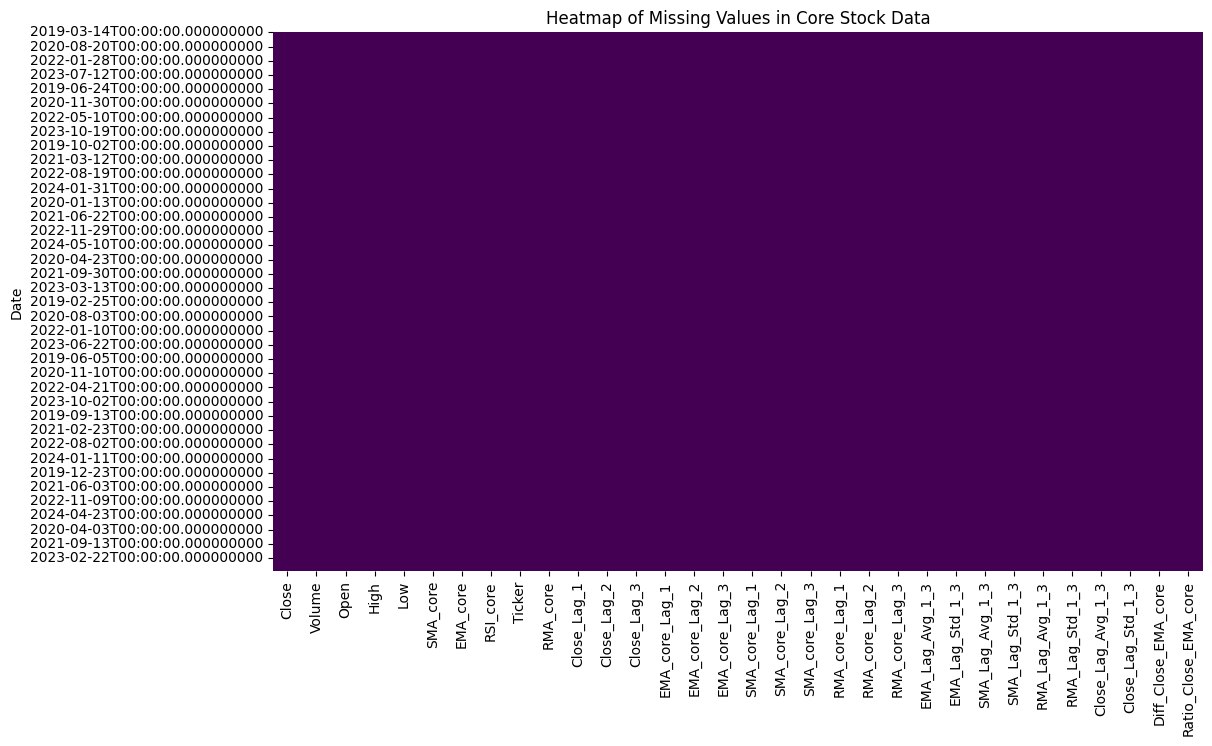

In [ ]:
plt.figure(figsize = (12,7))
sns.heatmap(core_stock_data.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

#### When looking above it really is hard to tell since each row that has missing values is only missing between 1-3 values.  There are only a few values to fill, most likely due to the overlapping of the lag windows.  Let's create a quick function to impute those values, and then fill each feature column that contained one.  We will follow with a quick check to see that there are no more remaining missing values.

In [ ]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

core_stock_data['Close_Lag_1'] = fill_missing_vals(core_stock_data['Close_Lag_1'])
core_stock_data['Close_Lag_2'] = fill_missing_vals(core_stock_data['Close_Lag_2'])
core_stock_data['Close_Lag_3'] = fill_missing_vals(core_stock_data['Close_Lag_3'])
core_stock_data['EMA_core_Lag_1'] = fill_missing_vals(core_stock_data['EMA_core_Lag_1'])
core_stock_data['EMA_core_Lag_2'] = fill_missing_vals(core_stock_data['EMA_core_Lag_2'])
core_stock_data['EMA_core_Lag_3'] = fill_missing_vals(core_stock_data['EMA_core_Lag_3'])
core_stock_data['SMA_core_Lag_1'] = fill_missing_vals(core_stock_data['SMA_core_Lag_1'])
core_stock_data['SMA_core_Lag_2'] = fill_missing_vals(core_stock_data['SMA_core_Lag_2'])
core_stock_data['SMA_core_Lag_3'] = fill_missing_vals(core_stock_data['SMA_core_Lag_3'])
core_stock_data['RMA_core_Lag_1'] = fill_missing_vals(core_stock_data['RMA_core_Lag_1'])
core_stock_data['RMA_core_Lag_2'] = fill_missing_vals(core_stock_data['RMA_core_Lag_2'])
core_stock_data['RMA_core_Lag_3'] = fill_missing_vals(core_stock_data['RMA_core_Lag_3'])
core_stock_data['EMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['EMA_Lag_Avg_1_3'])
core_stock_data['EMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['EMA_Lag_Std_1_3'])
core_stock_data['SMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['SMA_Lag_Avg_1_3'])
core_stock_data['SMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['SMA_Lag_Std_1_3'])
core_stock_data['RMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['RMA_Lag_Avg_1_3'])
core_stock_data['RMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['RMA_Lag_Std_1_3'])
core_stock_data['Close_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['Close_Lag_Avg_1_3'])
core_stock_data['Close_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['Close_Lag_Std_1_3'])

print(core_stock_data.isna().sum())

Close                   0
Volume                  0
Open                    0
High                    0
Low                     0
SMA_core                0
EMA_core                0
RSI_core                0
Ticker                  0
RMA_core                0
Close_Lag_1             0
Close_Lag_2             0
Close_Lag_3             0
EMA_core_Lag_1          0
EMA_core_Lag_2          0
EMA_core_Lag_3          0
SMA_core_Lag_1          0
SMA_core_Lag_2          0
SMA_core_Lag_3          0
RMA_core_Lag_1          0
RMA_core_Lag_2          0
RMA_core_Lag_3          0
EMA_Lag_Avg_1_3         0
EMA_Lag_Std_1_3         0
SMA_Lag_Avg_1_3         0
SMA_Lag_Std_1_3         0
RMA_Lag_Avg_1_3         0
RMA_Lag_Std_1_3         0
Close_Lag_Avg_1_3       0
Close_Lag_Std_1_3       0
Diff_Close_EMA_core     0
Ratio_Close_EMA_core    0
dtype: int64


# Looks good, now we can move on to scaling our new dataframe.

In [ ]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
#tickers = core_stock_data['Ticker'].values
#core_stock_data = core_stock_data.drop(columns = ['Ticker'])

# Initiate the scaler and transform the data.
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(core_stock_data)
#core_stock_scaled = pd.DataFrame(scaled_data, index = core_stock_data.index, columns = core_stock_data.columns)
#print(core_stock_scaled.head())

               Close    Volume      Open      High       Low  SMA_core  \
Date                                                                     
2019-03-14 -1.010398  0.038580 -1.009605 -1.015299 -1.006805 -1.062552   
2019-03-15 -1.005062  0.452947 -1.007484 -1.008167 -1.004140 -1.061304   
2019-03-18 -1.000821  0.109331 -1.005363 -1.005826 -0.999509 -1.059275   
2019-03-19 -1.004147  0.254746 -0.999669 -1.004502 -0.999215 -1.057581   
2019-03-20 -1.000508  0.238368 -1.004403 -1.003398 -1.001903 -1.055800   

            EMA_core  RSI_core  RMA_core  Close_Lag_1  ...  EMA_Lag_Avg_1_3  \
Date                                                   ...                    
2019-03-14 -1.040363  1.266968  0.782694    -1.010284  ...        -1.040951   
2019-03-15 -1.038819  1.340410  0.900346    -1.010284  ...        -1.040951   
2019-03-18 -1.037165  1.443013  0.978601    -1.004948  ...        -1.040179   
2019-03-19 -1.035710  1.136258  0.823821    -1.000706  ...        -1.039370   
2019-03

#### Now we can move on to the last part of our processing, the PCA or Principal Component Analysis.  Here we will look at reducing dimensionality of our scaled dataframe and reduce the variance.

In [ ]:
# Instantiate the pca variable and transform on our new data.
pca = PCA(n_components = None)
core_pca = pca.fit_transform(core_stock_scaled)

# The variables below are just being set up so we can use them in the following plots.
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [ ]:
explained_variance_trace = go.Scatter(
    x = list(range(1, len(explained_variance) + 1)),
    y = explained_variance,
    mode = 'lines+markers',
    name = 'Explained Variance',
    line = dict(color = 'blue')
)

cumulative_explained_variance_trace = go.Scatter(
    x = list(range(1, len(cumulative_explained_variance) + 1)),
    y = cumulative_explained_variance,
    mode = 'lines+markers',
    name = 'Cumulative Explained Variance',
    line = dict(color = 'green')
)

variance_threshold_trace = go.Scatter(
    x = [1, len(cumulative_explained_variance)],
    y = [0.95, 0.95],
    mode = 'lines',
    name = '95% Variance Threshold',
    line = dict(color = 'red', dash = 'dash')
)

fig = go.Figure(data = [explained_variance_trace, cumulative_explained_variance_trace, variance_threshold_trace])
fig.update_layout(
    title = 'Explained Variance by Principal Components',
    xaxis_title = 'Number of Components',
    yaxis_title = 'Variance Explained',
    template = 'plotly_dark'    
)

fig.show()

#### The above illustrates nicely what we wanted to see for our expected n_components for the PCA.  We are looking at both blue and green lines here, and need to decide which is best for our outcome.  For the CEV (Cumulative Explained Variance) n_components = 6 is right below the mark for 95% Variance met, and then looking at EV (Explained Variance) we are looking at when it "bottoms out" which would be when most of the variance has been explained.  This would be n_components = 3 for the above.  While this component value doesn't capture as much variance we would be dealing with less components which is beneficial for the model.  Meeting the threshold is always ideal however, and at n_components = 6 that is an acceptable component value to work with for our baseline model going forward.

#### Let's plot the first two components to see how they look.

In [ ]:
pca_df = pd.DataFrame(data = core_pca, columns = [f'PC{i+1}' for i in range(core_pca.shape[1])])

fig_pca = px.scatter(
    pca_df,
    x = 'PC1',
    y = 'PC2',
    color = tickers,
    title = 'PCA: First Two Principal Components',
    labels = {'PC1' : 'Principal Component 1', 'PC2' : 'Principal Component 2'},
    template = 'plotly_dark',
    opacity = 0.5
)

fig.update_traces(marker = dict(size = 4))

fig_pca.show()

#### Not a bad start, when messing with different setting on the Plotly graph above you can definitely see some of the clustering of some of the tickers.  Let's update our pca dataframe with our optimized number of components (n_components = 6) and see what changes.

In [ ]:
components_pca = PCA(n_components = 6)

core_pca_optimized = components_pca.fit_transform(core_stock_scaled)

pca_df_optimized = pd.DataFrame(data = core_pca_optimized, columns = [f'PC{i+1}' for i in range(6)])

fig_pca_optimized = px.scatter(
    pca_df_optimized,
    x = 'PC1',
    y = 'PC2',
    color = tickers,
    title = 'PCA: First Two Principal Components (n_components = 6)',
    labels = {'PC1' : 'Principal Component 1', 'PC2' : 'Principal Component 2'},
    template = 'plotly_dark',
    opacity = 0.5
)

fig_pca_optimized.update_traces(marker = dict(size = 4))

fig_pca_optimized.show()

#### It looks pretty much the same, which isn't entirely unexpected.  The first two principal components capture most of the significant data variance, which is why we plot them in PCA plots.  We will still move forward with 6 components as this number still could show underlying trends and relationships that these plots wouldn't be able to show us.

#### Let's save this notebook so we can use in our baseline modeling.

In [ ]:
# Need to convert the PCA_transformed data back to a dataframe and add back in our Ticker column first
core_stock_scaled['Ticker'] = tickers

core_stock_scaled_reset = core_stock_scaled.reset_index()


core_stock_scaled_reset.to_csv(os.path.join(project_root, 'data', 'core_stock_preprocessed.csv'), index = False)

core_stock_scaled_reset.shape


(13771, 33)